In [211]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

countries = CountryMetaDataFile().readMetadata()
dl = DataLib("SignalData")

In [212]:
# Setting up Bond Return Index variables
BondReturnIndex = dl.pull('BondRetIdx/LocalFX') # daily, represents accumulated returns from holding 10-year bonds
average = 'Equal Weighted Mean'
std = 'Equal Weighted Std'
BondReturnIndex[average] = BondReturnIndex.mean(axis=1) # global average
MonthlyBondReturnIndex = BondReturnIndex.resample('1M').mean()
MonthlyBondReturnIndex[average] = MonthlyBondReturnIndex.mean(axis=1) # global average

# Indicator 1: Bond Premium

* What it is: difference between the long rate and short rate
* What it means: reflects the slope of the yield curve
* What it tells us: the greater the bond premium, the greater the spread between long and short rates
* What we expect: typically the bond premium is positive (meaning that long rates > short rates) since there is more risk associated with holding bonds for longer
* What this tells us about bonds: steepening yield curves attracts investors with long positions

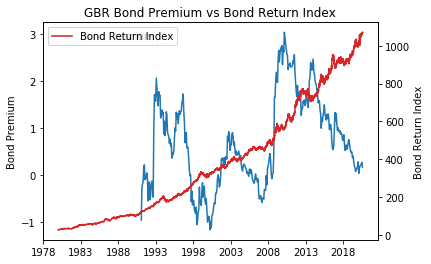

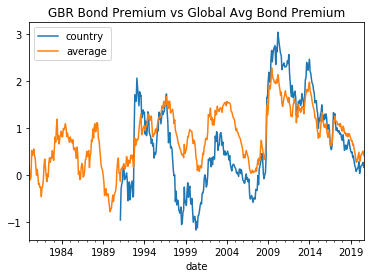

In [213]:
# Calculating Bond Premium for all countries
ShortRates = dl.pull('ShortRates') # monthly
LongRates = dl.pull('LongRates') # monthly, nominal yield on 10-year govenment issued bonds
BondPremium = LongRates - ShortRates
BondPremium[average] = BondPremium.mean(axis=1) # global average
BondPremium[std] = BondPremium.std(axis=1) # global std

country = 'GBR'

# Bond Premium vs. Bond Returns
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Premium'
ax1.plot(BondPremium[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Premium vs Bond Return Index')
plt.show()

# Bond Premium vs. Global Avg Bond Premium
BondPremium[country].plot()
BondPremium[average].plot()
plt.legend(['country', 'average'])
plt.title(f'{country} Bond Premium vs Global Avg Bond Premium')
plt.show()

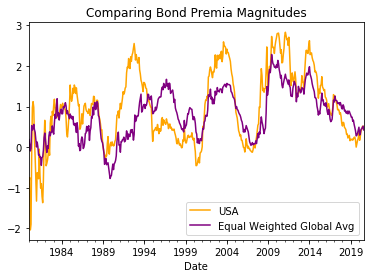

In [214]:
country = 'JPN'

# For Presentation
# Bond Premia Magnitude
#BondPremium['JPN'].plot()
BondPremium['USA'].plot(color='orange')
BondPremium[average].plot(color='purple')
plt.legend(['USA', 'Equal Weighted Global Avg'])
plt.title(f'Comparing Bond Premia Magnitudes')
plt.xlabel('Date')
plt.show()
plt.savefig('test.png')

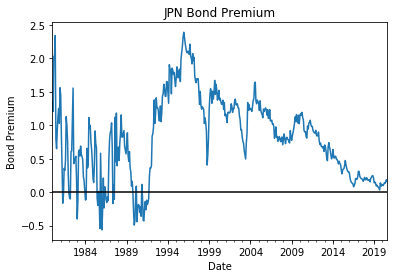

In [215]:
country = 'JPN'

# For Presentation
# Bond Premium
BondPremium[country].plot()
plt.title(f'{country} Bond Premium')
plt.xlabel('Date')
plt.ylabel('Bond Premium')
plt.axhline(y=0, color='k')# Plotted x axis to clarify positive/negative parts of graph 
plt.show()

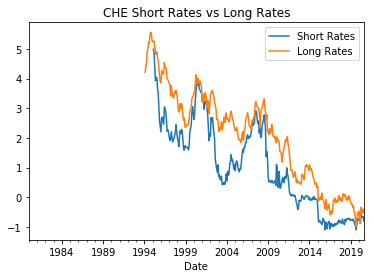

In [216]:
country = 'CHE'

# For Presentation
# Short Rates vs. Long Rates
ShortRates[country].plot()
LongRates[country].plot()
plt.legend(['Short Rates', 'Long Rates'])
plt.title(f'{country} Short Rates vs Long Rates')
plt.xlabel('Date')
plt.show()

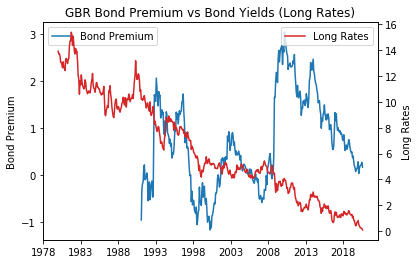

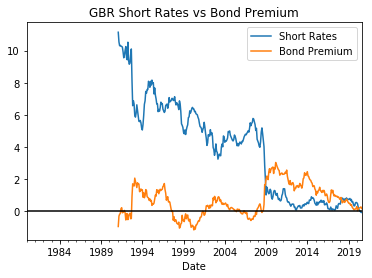

In [217]:
country = 'GBR'

# For Presentation
# Bond Premium vs. Long Rates
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Premium'
ax1.plot(BondPremium[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Long Rates'
ax2.plot(LongRates[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Premium vs Bond Yields (Long Rates)')
plt.show()

# Bond Premium vs. Short Rates
ShortRates[country].plot()
BondPremium[country].plot()
plt.legend(['Short Rates', 'Bond Premium'])
plt.title(f'{country} Short Rates vs Bond Premium')
plt.xlabel('Date')
plt.axhline(y=0, color='k')# Plotted x axis to clarify positive/negative parts of graph 
plt.show()

# LOGIC
* The bigger the Bond Premium, the steeper the yield curve, the bigger our long position
* If the Bond Premium is relatively bigger, our position should be positive (long)
* Curve is steepening if premium at given day is greater than some rolling average
* We can scale our Bond Premium by whether or not it is steepening before standardizing

In [241]:
# Takes in a country and returns prediction dataframe
def BondPremiumIndicator(country, window):
    
    # Set up monthly country data
    data = pd.DataFrame(MonthlyBondReturnIndex[country])
    data['BondPremium'] = BondPremium[country]
    
    # Prediction A: Prediction scaled by global average
    data['IndicatorA'] = (data['BondPremium'] - BondPremium[average]) / BondPremium[std]
    data['ScaledA'] = np.tanh(data['IndicatorA'])
    
    # Prediction B: Prediction scaled by domestic change in BP over inputted-month period
    data['IndicatorB'] = (data['BondPremium'] - data['BondPremium'].rolling(window).mean()) / data['BondPremium'].rolling(window).std() 
    data['ScaledB'] = np.tanh(data['IndicatorB'])
    
    # Prediction C: Prediction scaled by global average over inputted-month period
    data['IndicatorC'] = (data['BondPremium'].rolling(window).mean() - BondPremium[average].rolling(window).mean()) / BondPremium[average].rolling(window).std() 
    data['ScaledC'] = np.tanh(data['IndicatorC'])

    # Prediction D: Take average of A and B raw indicators, then scale
    data['IndicatorD'] = (data['IndicatorA'] + data['IndicatorB']) / 2
    data['ScaledD'] = np.tanh(data['IndicatorD'])

    # Plot indicators
    PlotAllIndicators(data,country)
    
    # Calculate P&L in Change Space
    data = PnLChangeSpace(data, country)
    
    # Calculate P&L in Change Space
    data = PnLReturnSpace(data, country)
    
    return data

In [242]:
# Calculate and display P&L values in change space from prediction dataframe
def PnLChangeSpace(data, country):
    
    # Calculate P&L in change space
    pnlChangeA = (1+data['ScaledA']) * data[country].shift(1).pct_change()
    pnlChangeB = (1+data['ScaledB']) * data[country].shift(1).pct_change()
    pnlChangeC = (1+data['ScaledC']) * data[country].shift(1).pct_change()
    pnlChangeD = (1+data['ScaledD']) * data[country].shift(1).pct_change()

    # Plot P&L curves in change space
    MonthlyBondReturnIndex[country].shift(1).pct_change().cumsum().plot(color="red")
    pnlChangeA.cumsum().plot()
    pnlChangeB.cumsum().plot()
    pnlChangeC.cumsum().plot(color="purple")
    pnlChangeD.cumsum().plot(color="green")    
    plt.legend(['Bond Return Index % Change','A: Relativized Across Countries', 'B: Normalized Through Time', 'C: Normalized then Relativized', 'D: Average of A & B'])
    plt.title(f'{country} P&L Curves in Change Space Using Bond Premium')
    plt.xlabel('Date')
    plt.show()
    
    return data

In [243]:
# Calculate and display P&L values in return space from prediction dataframe
def PnLReturnSpace(data, country):
    
    # Calculate P&L in return space
    pnlReturnA = data['ScaledA'] * MonthlyBondReturnIndex[country].diff().shift(1)
    pnlReturnB = data['ScaledB'] * MonthlyBondReturnIndex[country].diff().shift(1)
    pnlReturnC = data['ScaledC'] * MonthlyBondReturnIndex[country].diff().shift(1)
    pnlReturnD = data['ScaledD'] * MonthlyBondReturnIndex[country].diff().shift(1)

    # Plot P&L curves in return space
    MonthlyBondReturnIndex[country].plot(color="red")
    pnlReturnA.cumsum().plot()
    pnlReturnB.cumsum().plot()
    pnlReturnC.cumsum().plot(color="purple")
    pnlReturnD.cumsum().plot(color="green")    
    plt.legend(['Bond Return Index Diff','A: Relativized Across Countries', 'B: Normalized Through Time', 'C: Normalized then Relativized', 'D: Average of A & B'])
    plt.title(f'{country} P&L Curves in Return Space Using Bond Premium')
    plt.xlabel('Date')
    plt.show()
    
    return data

In [244]:
# Generates indicator graphs vs. Bond Return Index
def PlotAllIndicators(data,country):
    
    scaledIndicators = ['ScaledA', 'ScaledB', 'ScaledC', 'ScaledD']
    for indicator in scaledIndicators:
        
        # Plot indicator
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1_label = indicator
        ax1.plot(data[indicator].to_timestamp(), label = ax1_label)
        ax1.set_ylabel(ax1_label)
        ax1.legend()
        ax2_label = 'Bond Return Index'
        ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
        ax2.set_ylabel(ax2_label)
        ax2.legend()
        plt.title(f'{country} Bond Return Index vs {indicator}')
        plt.show()

In [245]:
# Test all countries
def TestAll():

    resultsAll = pd.DataFrame()
    all_countries = ShortRates.columns
        
    # Iterate over all countries and generate indicators and pnl curves
    for i in all_countries:
        resultCountry = BondPremiumIndicator(i,48)
        resultsAll[i] = [resultCountry['pnlA'].sum(),resultCountry['pnlB'].sum(),resultCountry['pnlC'].sum(),resultCountry['pnlBC'].sum(),MonthlyBondReturnIndex[i].shift(1).pct_change().sum()]
    
    return resultsAll

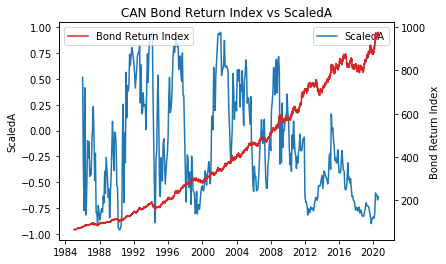

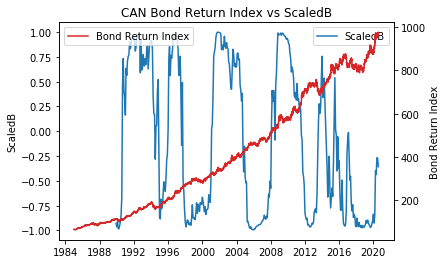

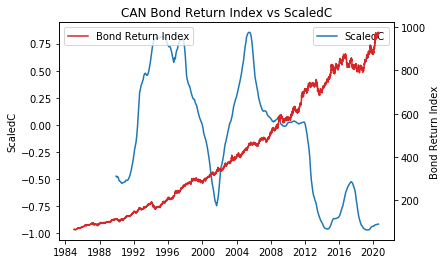

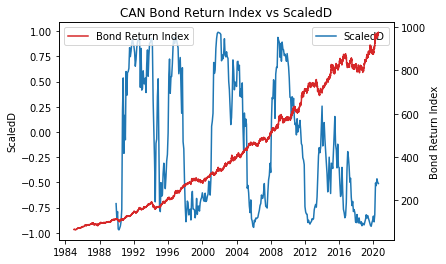

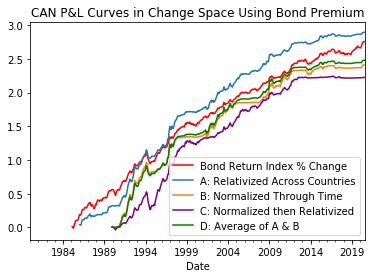

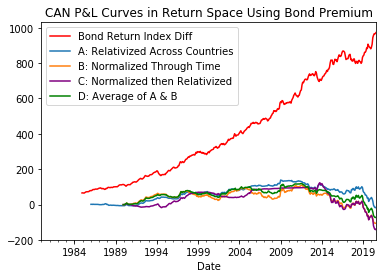

In [246]:
x = BondPremiumIndicator('CAN',48)

In [247]:
# risk adjusting (sharpe ratio)
# volatility adjusting 

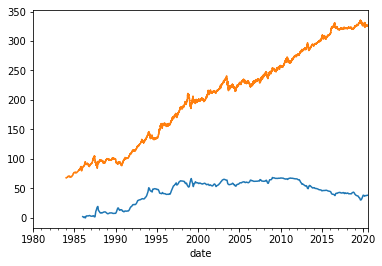

In [248]:
test = (x['IndicatorA'] * MonthlyBondReturnIndex['JPN'].diff().shift(1)).cumsum()
test.plot()
BondReturnIndex['JPN'].plot()
plt.show()

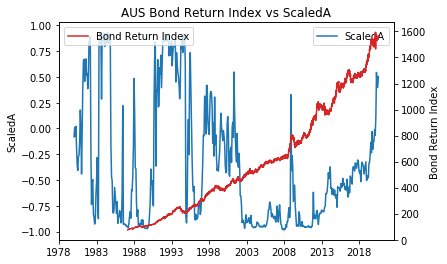

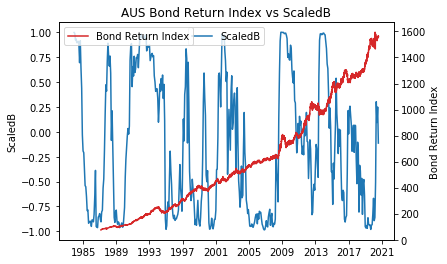

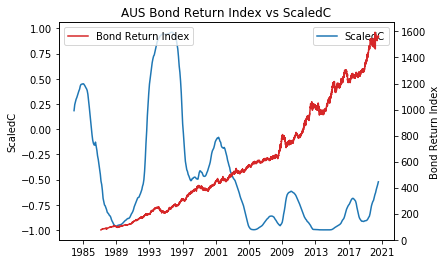

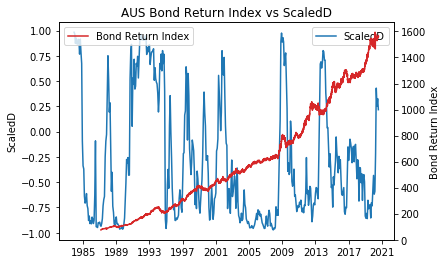

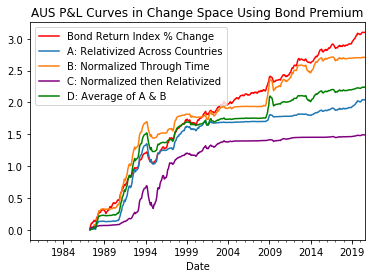

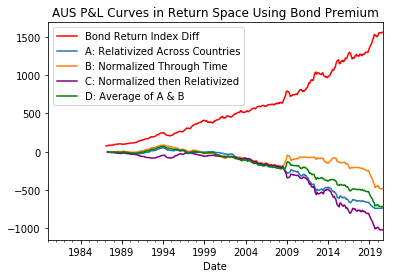

KeyError: 'pnlA'

In [249]:
TestAll()